# Simple Encoder CNN to get the $\phi_{CR}$ parameter of a CR image
---

---

In [1]:
import torch #should be installed by default in any colab notebook
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import h5py

from IPython import display as display_IPython

assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the functions and routines for the DL
### Define the model and its constructor

In [ ]:
# FORWARDA KONTROLEU!!! NORAMLIZAZIÑOANA ONDO BADOAN EDO ZER!

In [2]:
class Simple_Encoder(nn.Module):
    def __init__(self, X=302, feats_1=15, feats_2=20, feats_3=20, feats_4=20,
                 prop1=3, prop2=2, prop3=1, av_pool1_div=4, conv4_feat_size=15, av_pool2_div=10, 
                 out_fc_1=10,
                 dropout_p1=0.2, dropout_p2=0.1
                ): 
        # propj is such that the_ image getting out from stage j is propj/prop_{j-1}-ths of the previous (with j=0 being 5)
        # clearly, prop_{j-1}>prop_{j}>...
        # 2X+1 will be assumed to be divisible by 5
        assert((2*X+1)%5==0)
        assert(prop1>prop2)
        assert(prop2>prop3)
        assert((int((prop3*(2*X+1)/5)/av_pool1_div)-conv4_feat_size)>0)
        
        
        super(Simple_Encoder, self).__init__()
        # in is [epoch_size, 1, 2X+1, 2X+1]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=feats_1, 
                               kernel_size = int((2*X+1)/5*(5-prop1)+1), bias=True) 
        # out conv1 [epoch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        self.conv2 = nn.Conv2d(in_channels=feats_1, out_channels=feats_2, 
                               kernel_size = int((2*X+1)/5*(prop1-prop2)+1), bias=True) 
        # out conv1 [epoch_size, feats_2, prop2*(prop1*(2X+1)/5)/prop1, prop2*(prop1*(2X+1)/5)/prop1]
        # that is [epoch_size, feats_2, prop2*(2X+1)/5), prop2*(2X+1)/5)]
        self.conv3 = nn.Conv2d(in_channels=feats_2, out_channels=feats_3, 
                               kernel_size = int((2*X+1)/5*(prop2-prop3)+1), bias=True)
        # out conv3 is [epoch_size, feats_3, prop3*(2X+1)/5), prop3*(2X+1)/5)]

        self.avPool1 = nn.AvgPool2d(kernel_size= int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
        
        self.conv4 = nn.Conv2d(in_channels=feats_3, out_channels=feats_4, 
                              kernel_size= int((prop3*(2*X+1)/5)/av_pool1_div+1)-conv4_feat_size+1, bias=True)
        # [epoch_size, feats_4, conv4_feat_size, conv4_feat_size]
        
        self.avPool2 = nn.AvgPool2d(kernel_size= int(conv4_feat_size*(1-1/av_pool2_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_4, conv4_feat_size/av_pool2_div+1, conv4_feat_size/av_pool2_div+1]
        
        self.in_fc = feats_4*int(conv4_feat_size/av_pool2_div+1)**2
        
        self.fc1 = nn.Linear(in_features=self.in_fc, out_features=out_fc_1, bias=True)
        self.fc2 = nn.Linear(in_features=out_fc_1, out_features=1, bias=True)
        
        self.dropout1 = nn.Dropout(p=dropout_p1, inplace=False)
        self.dropout2 = nn.Dropout(p=dropout_p2, inplace=False)
        self.relu = torch.nn.functional.relu

        self.batchNorm2 = nn.BatchNorm2d(num_features=feats_2)
        self.batchNorm4 = nn.BatchNorm2d(num_features=feats_4)

    def forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
        x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]).float() # [batch_size, 1, 2X+1, 2X+1]
        
        # Normalize to unity the float image
        x = x/x.amax(dim=(2,3), keepdim=True)[0] # [batch_size, 1, 2X+1, 2X+1]
        print(x.shape)
        rasie ValueError
        
        x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        
        x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]

        
        x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]

        
        x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]

        
        x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]

        
        x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]

        
        x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]

        
        x = self.fc2( self.relu( self.fc1(x) ) ) #[batch_size, 1]
        
        return x
    

In [3]:
# subroutine to count number of parameters in the model
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

### The routines to validate and train

In [4]:
@torch.no_grad()  # prevent this function from computing gradients 
def validate_epoch(criterion, model, dataloader): #show_confusion_matrix = False):

    val_loss = 0
    max_abs_error = torch.Tensor([0]).to(device)
    mean_abs_error = 0
    preds = torch.Tensor().to(device)
    targets = torch.Tensor().to(device)

    model.eval() # disable the dropout, among others

    for batch_id, data, target in enumerate(dataloader):
        
        data, target = data.to(device), target.to(device)       
        prediction = model(data)
        target = target.view(prediction.shape)
        loss = criterion(prediction, target)
        val_loss += loss.item()                                                              
        max_abs_error = torch.maximum(torch.max(torch.abs(prediction-target), 0).values, max_abs_error)
        mean_abs_error += torch.sum(torch.abs(prediction-target), 0)

    val_loss /= len(dataset)
    mean_abs_error /= len(dataset)
    #accuracy = 100. * correct / len(loader.dataset)
    print(f'\nValidation set: Average loss: {val_loss:.4f}, Average Abs Error: {np.array(mean_abs_error.cpu()/len(dataset))}, Maximum Abs Error: {np.array(max_abs_error.cpu())} \n')

    #if show_confusion_matrix:
    #    visualize_confusion_matrix(preds.to(torch.device('cpu')), targets.to(torch.device('cpu')))

    return val_loss


def train_epoch(epoch, criterion, model, optimizer, dataloader, print_loss_every_batches=20,
                optimizer_step_every_batches=1):
    
    total_loss = 0.0

    model.train()

    optimizer.zero_grad()

    
    for batch_id, data, target in enumerate(dataloader):
        print(data.shape, target.shape)
        raise ValueError
        # ikusi ia ondo ataten badeuzen data eta targeta

        data, target = data.to(device), target.to(device)

        prediction = model(data)
        loss = criterion(prediction, target)
        loss.backward()
        
        if batch_id % optimizer_step_every_batches==optimizer_step_every_batches-1:
            optimizer.step()
            optimizer.zero_grad()
        
        # print loss every N batches
        if batch_id % print_loss_every_batches == print_loss_every_batches-1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_id * len(data), len(dataset),
                print_loss_every_batches * batch_id / len(dataset), loss.item()))


        total_loss += loss.item()  #.item() is very important here
        # Why?-> In order to avoid having total_loss as a tensor in the gpu

    return total_loss / len(dataset)

### The full training loop

In [5]:
def full_training_loop(model, criterion, optimizer, train_loader, test_loader, epochs=10,
                       print_loss_every_batches=20, validate_every_epochs=2, optimizer_step_every_batches=1):
    losses = {"train": [], "val": []}
    %matplotlib inline
    for epoch in range(epochs):

        train_loss = train_epoch(epoch, criterion, model, optimizer, train_loader,
                                 print_loss_every_batches=print_loss_every_batches,
                                optimizer_step_every_batches=optimizer_step_every_batches)
        display_IPython.clear_output(wait=True)
        if epoch%validate_every_epochs==0 and epoch!=0:
            val_loss = validate_epoch(criterion, model, test_loader)
        losses["train"].append(train_loss)
        losses["val"].append(val_loss)        
        plt.plot(losses["train"], label="log training loss")
        plt.plot(losses["val"], label="log validation loss")
        plt.yscale('log')
        plt.legend()
        plt.pause(0.001)
        plt.show()   
    return losses

### The Dataset class and Data Sampler

In [ ]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader

class ImageDataset(Dataset):
    def __init__(self, GT_file_path, images_dir_path):
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(GT_file_path)))
        self.images_dir_path = images_dir_path
        self.len_data = len(self.GT_labels)

    def __len__(self):
        return self.len_data

    def __getitem__(self, idx):
        img_path = f"{self.img_dir}/IM_{self.df_GTs.iloc[idx,0]}_phiCR_{self.df_GTs.iloc[idx,0]}.png"
        image = read_image(img_path)
        raise ValueError
        # txekieu image shape badan guretena nik #[nb, 2x+1, 2x+1]
        label = self.df_GTs.iloc[idx, 1]
        return image, label

---
# Initialize the dataset and sampler (choose the number of batches per epoch, and their length) and fix the artificial noise hyperparameters

Note that since in each epoch the dataset shown to the model will be random, we can use the same dataset as a validation set.

In [8]:
GT_file_path_train = f""
images_dir_path_train =f"" 
GT_file_path_test = f""
images_dir_path_test = f""

total_epochs = 20
batch_size = 8
validate_every_epochs=10
optimizer_step_every_batches=2
worker_num=6


In [ ]:
training_data = ImageDataset(GT_file_path_train, images_dir_path_train)
test_data = ImageDataset(GT_file_path_test, images_dir_path_test)

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=worker_num,
                              pin_memory=True, drop_last=False, persistent_workers=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=worker_num, 
                             pin_memory=True, drop_last=False, persistent_workers=False)


assert(len(train_dataloader)%batch_size==0) # make batch_size an integer proportion of data files
batch_number_per_epoch = len(train_dataloader)/batch_size
assert(batch_number_per_epoch%optimizer_step_every_batches==0) # make optimizer steps every divisble number of its

# Fix the Hyperparameters and Initialize the Model and the Optimizer

In [11]:
feats_1=15
feats_2=20
feats_3=20
feats_4=20
prop1=3
prop2=2
prop3=1
av_pool1_div=4
conv4_feat_size=15
av_pool2_div=10
out_fc_1=10
dropout_p1=0.2
dropout_p2=0.1

In [12]:
model = Simple_Encoder( X=X, feats_1=feats_1, feats_2=feats_2, feats_3=feats_3, feats_4=feats_4,
                 prop1=prop1, prop2=prop2, prop3=prop3, av_pool1_div=av_pool1_div, conv4_feat_size=conv4_feat_size, av_pool2_div=av_pool2_div, 
                 out_fc_1=out_fc_1,
                 dropout_p1=dropout_p1, dropout_p2=dropout_p2 ) 

print(f"Number of parameters {get_n_params(model)}")

# In case we wish to transfer the learned parameters of another run
#checkpoint = torch.load(f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Simple_Encoder/Model_opt_Adam_8sperbatchx10batchperepx20epochs_samples_feats_1={feats_1}_feats_2={feats_2}_feats_3={feats_3}_feats_4={feats_4}_prop1={prop1}_prop2={prop2}_prop3={prop3}_av_pool1_div={av_pool1_div}_conv4_feat_size={conv4_feat_size}_av_pool2_div={av_pool2_div}_out_fc_1={out_fc_1}_dropout_p1={dropout_p1}_dropout_p2={dropout_p2}.pt")

# move model to gpu if available
model.to(device)

#model.load_state_dict(checkpoint['model'])


# Initialize the weights of the model! Default initialization might already be fine!

# we can use a MSE loss for the regression task we have in hands
criterion = nn.MSELoss()

# we will choose as optimizer the 
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1, lr_decay=0.01, weight_decay=0.3,
#                                initial_accumulator_value=0, eps=1e-10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.05, betas=(0.99, 0.9999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer.load_state_dict(checkpoint['optimizer'])

Number of parameters 11421144


# Run the Training

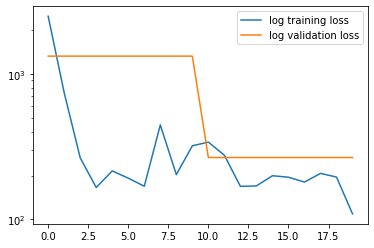

CPU times: user 1h 8min 9s, sys: 2.1 s, total: 1h 8min 11s
Wall time: 1h 8min 5s


In [13]:
%%time
losses = full_training_loop(model, criterion, optimizer, train_dataloader, test_dataloader, 
                    epochs=total_epochs, print_loss_every_batches=1, validate_every_epochs=validate_every_epochs,
                           optimizer_step_every_batches=optimizer_step_every_batches)
# Execute the training and validation

# Final Validation

In [14]:
print("\n\n\nFINAL VALIDATION! ####################################################\n\n")
print("Train Set")
validate_epoch(nn.MSELoss(), model, sampler, dataset)
print("Test Set")
validate_epoch(nn.MSELoss(), model, sampler, dataset)




FINAL VALIDATION! ####################################################


Train Set

Validation set: Average loss: 26.7044, Average Abs Error: [0.28822225 0.09161478 0.00560787 0.01008424], Maximum Abs Error: [51.711906  17.478317   0.7793498  3.1870623] 

Test Set

Validation set: Average loss: 22.7572, Average Abs Error: [0.27275747 0.1009666  0.00621822 0.01093568], Maximum Abs Error: [55.151497   18.7453      0.93089575  5.125745  ] 



22.75722026824951

# Save the resulting model weights

In [17]:
torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Simple_Encoder/Model_opt_Adam_it_2_8sperbatchx10batchperepx20epochs_samples_feats_1={feats_1}_feats_2={feats_2}_feats_3={feats_3}_feats_4={feats_4}_prop1={prop1}_prop2={prop2}_prop3={prop3}_av_pool1_div={av_pool1_div}_conv4_feat_size={conv4_feat_size}_av_pool2_div={av_pool2_div}_out_fc_1={out_fc_1}_dropout_p1={dropout_p1}_dropout_p2={dropout_p2}.pt")

In [18]:
raise ValueError

ValueError: 

# Charge models and do inference

In [92]:
checkpoint = torch.load(f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Simple_Encoder/Model_opt_Adam_8sperbatchx10batchperepx20epochs_samples_feats_1={feats_1}_feats_2={feats_2}_feats_3={feats_3}_feats_4={feats_4}_prop1={prop1}_prop2={prop2}_prop3={prop3}_av_pool1_div={av_pool1_div}_conv4_feat_size={conv4_feat_size}_av_pool2_div={av_pool2_div}_out_fc_1={out_fc_1}_dropout_p1={dropout_p1}_dropout_p2={dropout_p2}.pt")

model = Simple_Encoder( X=X, feats_1=feats_1, feats_2=feats_2, feats_3=feats_3, feats_4=feats_4,
                 prop1=prop1, prop2=prop2, prop3=prop3, av_pool1_div=av_pool1_div, conv4_feat_size=conv4_feat_size, av_pool2_div=av_pool2_div, 
                 out_fc_1=out_fc_1,
                 dropout_p1=dropout_p1, dropout_p2=dropout_p2 ) 

model.to(device)
model.load_state_dict(checkpoint['model'])


# And we will use the same dataset to convert the experimental images to iX (not apply noise ofcourse)
dataset = CR_Dataset(D_matrix_file_path=D_matrix_file_path,
            ID_file_path =ID_file_path, 
            device = device,
            X=X, generate_images_w_depth=generate_images_w_depth, random_seed=random_seed 
            )

In [18]:
# Create and display a FileChooser widget
from ipyfilechooser import FileChooser
path="/home/oiangu/Desktop/Conical_Refraction_Polarimeter"
fc = FileChooser(path+'/LAB/EXPERIMENTAL/Fotos_Turpin/Day2/laser_gaussian_thesis/')
display(fc)

FileChooser(path='/home/oiangu/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/Day2/laser…

### Choose a single experimental image to predict

<IPython.core.display.Javascript object>


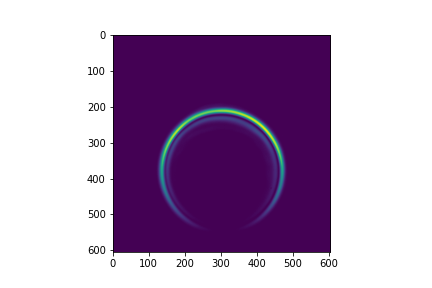

In [23]:
import cv2
image_full_path=fc.selected
#image_full_path="/home/oiangu/Desktop/Conical_Refraction_Polarimeter/Experimental_Stuff/Fotos_Turpin/Day2/laser_gaussian_thesis/All_Taken_Photos/sin_el_positivo.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)
if im is None:
    print(f" Unable to import image {image_full_path}")
    raise ValueError
# Center in gravicenter, generating iX
im = np.asarray((dataset.compute_raw_to_centered_iX(torch.from_numpy(im).unsqueeze(0).to(device))).to('cpu').squeeze(0))
plt.imshow(im)
plt.show()

### Plot its Profiles

<IPython.core.display.Javascript object>


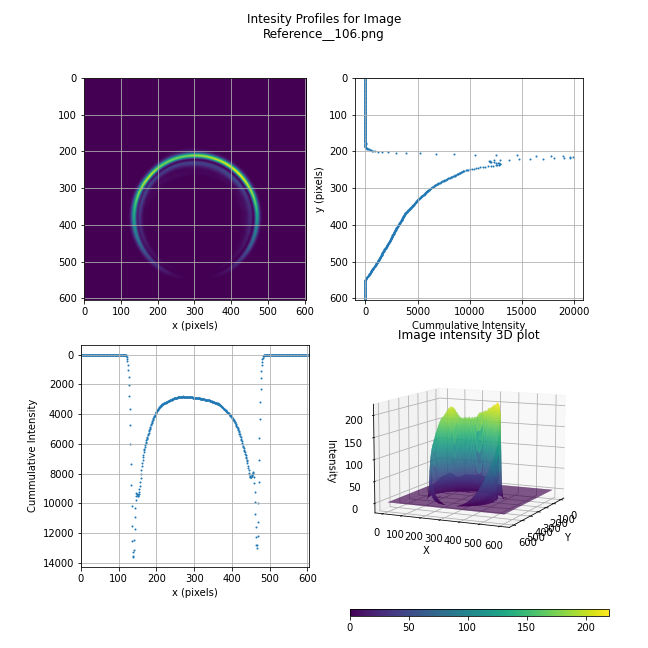

In [26]:
plot3d_resolution=0.7

%matplotlib notebook

prof_x=np.sum(im, axis=0)
prof_y=np.sum(im, axis=1)
fig = plt.figure(figsize=(2*4.5, 2*4.5))
axes=fig.subplots(2,2)

cm=axes[0, 0].imshow(im, cmap='viridis')
axes[0,0].grid(True)
axes[0,1].scatter(prof_y, np.arange(len(prof_y)), s=1, label=f'Intensity profile in y')
axes[0,1].set_ylim((0,len(prof_y)))
axes[0,1].invert_yaxis()
axes[1,0].scatter(np.arange(len(prof_x)), prof_x, s=1, label=f'Intensity profile in y')
axes[1,0].set_xlim((0,len(prof_x)))
axes[1,0].invert_yaxis()
axes[0,0].set_xlabel("x (pixels)")
#axes[0,0].set_ylabel("y (pixels)")
axes[0,1].set_xlabel("Cummulative Intensity")
axes[0,1].set_ylabel("y (pixels)")
axes[1,0].set_ylabel("Cummulative Intensity")
axes[1,0].set_xlabel("x (pixels)")
axes[1,0].grid(True)
axes[0,1].grid(True)
axes[1,1].set_visible(False)
ax = fig.add_subplot(224, projection='3d')
Xs,Ys = np.meshgrid(np.arange(len(prof_y)),np.arange(len(prof_x)))
fig.suptitle(f"Intesity Profiles for Image\n{image_full_path.split('/')[-1]}")
files_for_gif=[]
cbax=fig.add_axes([0.54,0.05,0.4,0.01])
fig.colorbar(cm, ax=axes[0,0], cax=cbax, orientation='horizontal')
theta=25
phi=30
ax.plot_surface(Xs, Ys, im.T, rcount=int(len(prof_y)*plot3d_resolution), ccount=int(len(prof_x)*plot3d_resolution), cmap='viridis') # rstride=1, cstride=1, linewidth=0
#cset = ax.contourf(X, Y, im, 2, zdir='z', offset=-20, cmap='viridis', alpha=0.5)
#cset = ax.contourf(X, Y, im, 1, zdir='x', offset=-8, cmap='viridis')
#cset = ax.contourf(X, Y, im, 1, zdir='y', offset=0, cmap='viridis')
ax.set_xlabel('Y')
#ax.set_xlim(-8, 8)
ax.set_ylabel('X')
#ax.set_ylim(-10, 8)
ax.set_zlabel('Intensity')
ax.set_zlim(-0.078*np.max(im), np.max(im))
ax.set_title("Image intensity 3D plot")
ax.view_init(10, theta)
#ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.3, 1.3, 1.3, 1]))
plt.show()

### Get NN predictions for $R_0, w_0, \phi_{CR}, Z$

In [73]:
(2.230889320373535)*180/np.pi

127.82054261821214

In [94]:
# pb
print(predictions)

tensor([97.7537, 23.7247,  0.6049,  1.8242], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [90]:
labs[0]

tensor([165.6522,  23.3043,   0.0000,   2.4780], device='cuda:0')

In [20]:
model.eval()
predictions = model(torch.from_numpy(im).to(device).unsqueeze(0))[0]
print(f"Predicted R_0 {predictions[0]}, w_0 {predictions[1]}, Z {predictions[2]}, phiCR {predictions[3]}")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {predictions[3]/2}")

Predicted R_0 136.84010314941406, w_0 23.58487319946289, Z 0.6923366785049438, phiCR 3.058746814727783


Predicted Polarization plane -relative to the image plane w axis- is 1.5293734073638916


In [25]:
(3.05874-0.389729)*180/np.pi

152.92306577399134

In [ ]:
# ref

In [24]:
model.eval()
predictions = model(torch.from_numpy(im).to(device).unsqueeze(0))[0]
print(f"Predicted R_0 {predictions[0]}, w_0 {predictions[1]}, Z {predictions[2]}, phiCR {predictions[3]}")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {predictions[3]/2}")

Predicted R_0 125.92003631591797, w_0 20.300323486328125, Z 0.7235177755355835, phiCR 0.389729380607605


Predicted Polarization plane -relative to the image plane w axis- is 0.1948646903038025


In [ ]:
before stdrd

In [49]:
model.eval()
predictions = model(torch.from_numpy(im).to(device).unsqueeze(0))[0]
print(f"Predicted R_0 {predictions[0]}, w_0 {predictions[1]}, Z {predictions[2]}, phiCR {predictions[3]}")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {predictions[3]/2}")

Predicted R_0 96.95147705078125, w_0 23.52690887451172, Z 0.5988854169845581, phiCR 1.9131122827529907


Predicted Polarization plane -relative to the image plane w axis- is 0.9565561413764954


In [53]:
#sin el negativo
(1.252748727798462-0.9565561413764954)*180/np.pi*2

33.94117025008515

In [33]:
model.eval()
predictions = model(torch.from_numpy(im).to(device).unsqueeze(0))[0]
print(f"Predicted R_0 {predictions[0]}, w_0 {predictions[1]}, Z {predictions[2]}, phiCR {predictions[3]}")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {predictions[3]/2}")

Predicted R_0 95.93550109863281, w_0 23.233444213867188, Z 0.5817143321037292, phiCR 2.505497455596924


Predicted Polarization plane -relative to the image plane w axis- is 1.252748727798462


In [54]:
#sin el positivo
(0.8978646397590637-0.9565561413764954)*180/np.pi*2

-6.725550671928156

In [36]:
model.eval()
predictions = model(torch.from_numpy(im).to(device).unsqueeze(0))[0]
print(f"Predicted R_0 {predictions[0]}, w_0 {predictions[1]}, Z {predictions[2]}, phiCR {predictions[3]}")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {predictions[3]/2}")

Predicted R_0 97.3699951171875, w_0 23.632488250732422, Z 0.6008874773979187, phiCR 1.7957292795181274


Predicted Polarization plane -relative to the image plane w axis- is 0.8978646397590637


In [55]:
#con los dos
(0.9729214310646057-0.9565561413764954)*180/np.pi*2

1.875324059275381

In [40]:
model.eval()
predictions = model(torch.from_numpy(im).to(device).unsqueeze(0))[0]
print(f"Predicted R_0 {predictions[0]}, w_0 {predictions[1]}, Z {predictions[2]}, phiCR {predictions[3]}")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {predictions[3]/2}")

Predicted R_0 96.53677368164062, w_0 23.424423217773438, Z 0.5946609377861023, phiCR 1.9458428621292114


Predicted Polarization plane -relative to the image plane w axis- is 0.9729214310646057


### Get the non-black-box algorithm estimate for $\phi_{CR}$

In [ ]:
import os
os.chdir(f"../../..")
import sys
from SOURCE.CLASS_CODE_GPU_Classes import *
from SOURCE.CLASS_CODE_Image_Manager import *
from SOURCE.CLASS_CODE_Polarization_Obtention_Algorithms import Rotation_Algorithm, Mirror_Flip_Algorithm, Gradient_Algorithm
import numpy as np
import json
import cv2
import pandas as pd
import matplotlib.pyplot as plt

image=im.copy()
saturation=0.9
pol_or_CR="pol" 
deg_or_rad="deg" # for the final output
image_depth=8 # or 16 bit per pixel
image_shortest_side=540
randomization_seed=666
recenter_average_image=False


# 5. POLARIZATION RELATIVE ANGLES ###################################
# Mirror with affine interpolation & Rotation Algorithms will be employed
# Each using both Fibonacci and Quadratic Fit Search
# Also a gradient algorithm
theta_min_Rot=-np.pi
theta_max_Rot=np.pi
rad_min_Grav=3
rad_max_Grav=image_shortest_side
theta_min_Mir=0
theta_max_Mir=np.pi
initial_guess_delta_rad=0.1
initial_guess_delta_pix=10
use_exact_gravicenter=True
precision_quadratic=1e-10
max_it_quadratic=100
cost_tolerance_quadratic=1e-14
precision_fibonacci=1e-10
max_points_fibonacci=100
cost_tolerance_fibonacci=1e-14


##################################################################
##################################################################
im_type=np.uint16 if image_depth==16 else np.uint8
max_intensity=65535 if image_depth==16 else 255
np.random.seed(randomization_seed)
polCR=1 if pol_or_CR=='CR' else 0.5

# 6. POLARIZATION RELATIVE ANGLES ###################################
# Mirror with affine interpolation & Rotation Algorithms will be employed
# Each using both Fibonacci and Quadratic Fit Search
# Results will be gathered in a table and outputed as an excel csv
# Mock Image Loader
# Computar el angulo de cada uno en un dataframe donde una de las entradas sea results y haya un result per fibo qfs y per rotation y mirror affine. Y luego procesar en un 7º paso estos angulos para obtener los angulos relativos etc y perhaps hacer tablucha con ground truth menos el resulting delta angle medido por el algoritmo
image_loader = Image_Manager(mode=X, interpolation_flag=None)
# Define the ROTATION ALGORITHM
rotation_algorithm = Rotation_Algorithm(image_loader,
    theta_min_Rot, theta_max_Rot, None,
    initial_guess_delta_rad, use_exact_gravicenter, initialize_it=False)

# Define the Affine Mirror algorithm
mirror_algorithm = Mirror_Flip_Algorithm(image_loader,
    theta_min_Mir, theta_max_Mir, None,
    initial_guess_delta_rad, method="aff", left_vs_right=True, use_exact_gravicenter=use_exact_gravicenter, initialize_it=False)

# Define the Gradient algorithm
gradient_algorithm = Gradient_Algorithm(image_loader,
        rad_min_Grav, rad_max_Grav,
        initial_guess_delta_pix,
        use_exact_gravicenter)

# A dictionary to gather all the resulting angles for each image

individual_image_results = { 'polarization_method':[], 'optimization_1d':[], 'found_phiCR':[], 'predicted_opt_precision':[] }

def to_result_dict(result_dict, alg, alg_name, opt_name, im_names):
    for key, name in zip(alg.times.keys(), im_names):
        result_dict['polarization_method'].append(alg_name)
        result_dict['optimization_1d'].append(opt_name)
        result_dict['found_phiCR'].append(alg.angles[key])
        result_dict['predicted_opt_precision'].append(alg.precisions[key])
image_container=np.zeros( (1, 2*X+1, 2*X+1), dtype=np.float64)
image_names=[]
# charge the image
image_container[0]=image.astype(np.float64)
image_names.append(f"{fc.selected_filename}")

# charge the image loader:
image_loader.import_converted_images_as_array(image_container, image_names)
# Execute the Rotation and Mirror Algorithms:
# ROTATION ######
interpolation_flag=None
# the interpolation algorithm used in case we disbale its usage for the iX image obtention will be the Lanczos one
rotation_algorithm.interpolation_flag=interpolation_flag if interpolation_flag is not None else cv2.INTER_CUBIC
rotation_algorithm.reInitialize(image_loader)
rotation_algorithm.quadratic_fit_search(precision_quadratic, max_it_quadratic, cost_tolerance_quadratic)
to_result_dict( individual_image_results, rotation_algorithm, "Rotation", "Quadratic", image_names)
rotation_algorithm.reInitialize(image_loader)
rotation_algorithm.fibonacci_ratio_search(precision_fibonacci, max_points_fibonacci, cost_tolerance_fibonacci)
to_result_dict( individual_image_results, rotation_algorithm, "Rotation", "Fibonacci", image_names)

# MIRROR #######
mirror_algorithm.interpolation_flag=interpolation_flag if interpolation_flag is not None else cv2.INTER_CUBIC
mirror_algorithm.reInitialize(image_loader)
mirror_algorithm.quadratic_fit_search(precision_quadratic, max_it_quadratic, cost_tolerance_quadratic)
to_result_dict( individual_image_results, rotation_algorithm, "Mirror", "Quadratic", image_names)
mirror_algorithm.reInitialize(image_loader)
mirror_algorithm.fibonacci_ratio_search(precision_fibonacci, max_points_fibonacci, cost_tolerance_fibonacci)
to_result_dict( individual_image_results, rotation_algorithm, "Mirror", "Fibonacci", image_names)

# GRADIENT #######
optimal_masked_gravs={}
optimal_radii={}
grav=compute_intensity_gravity_center(image)

gradient_algorithm.interpolation_flag=interpolation_flag if interpolation_flag is not None else cv2.INTER_CUBIC
gradient_algorithm.reInitialize(image_loader)
gradient_algorithm.quadratic_fit_search(precision_quadratic, max_it_quadratic, cost_tolerance_quadratic)
to_result_dict( individual_image_results, gradient_algorithm, "Gradient", "Quadratic", image_names)
#optimal_masked_gravs['quad'] = gradient_algorithm.masked_gravs[f"Quadratic_Search_{fc.selected_filename}"]
#optimal_radii['quad'] = gradient_algorithm.optimals[f"Quadratic_Search_{fc.selected_filename}"]

gradient_algorithm.reInitialize(image_loader)
gradient_algorithm.fibonacci_ratio_search(precision_fibonacci, max_points_fibonacci, cost_tolerance_fibonacci)
to_result_dict( individual_image_results, gradient_algorithm, "Gradient", "Fibonacci", image_names)

#optimal_masked_gravs['fibo'] = gradient_algorithm.masked_gravs[f"Fibonacci_Search_{fc.selected_filename}"]
#optimal_radii['fibo'] = gradient_algorithm.optimals[f"Fibonacci_Search_{fc.selected_filename}"]

#masked_grav=(optimal_masked_gravs['quad']+optimal_masked_gravs['fibo'])/2.0
#optimal_radi = (optimal_radii['quad']+optimal_radii['fibo'])/2
#print(f"\n\nOptimal masked gravs: {optimal_masked_gravs}\nOptimal radii: {optimal_radii}\n\n\n")
print(pd.DataFrame.from_dict(individual_image_results))

# 7. PROCESS FINAL RESULTS ##########################################
def angle_to_pi_pi( angle): # convert any angle to range ()-pi,pi]
    angle= angle%(2*np.pi) # take it to [-2pi, 2pi]
    return angle-np.sign(angle)*2*np.pi if abs(angle)>np.pi else angle    

average_found_phiCR=np.mean([angle_to_pi_pi(phi) for i,phi in enumerate(individual_image_results['found_phiCR']) if individual_image_results['polarization_method'][i]!='Gradient'])
print("Average found phiCR:", average_found_phiCR)
#print(f"\n\nPredicted slope for main axis: by Gradient {(masked_grav[0]-grav[0])/(masked_grav[1]-grav[1])} and by the others averaged {np.tan(-average_found_phiCR)}")

In [3]:
'''
def forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
    x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]) # [batch_size, 1, 2X+1, 2X+1]
    X=302
    feats_1=15
    feats_2=20
    feats_3=20
    feats_4=20
    prop1=3
    prop2=2
    prop3=1
    av_pool1_div=4
    conv4_feat_size=15
    av_pool2_div=10
    out_fc_1=10 
    print(x.shape, 2*X+1)

    x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
    print("conv1",x.shape, prop1*(2*X+1)/5)


    x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]
    print("conv2",x.shape,  prop2*(2*X+1)/5)


    x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]
    print("conv3",x.shape,  prop3*(2*X+1)/5)


    x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
    print("av_pool1",x.shape, int((prop3*(2*X+1)/5)/av_pool1_div))


    x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]
    print("conv4+batchn",x.shape, conv4_feat_size)


    x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]
    print("av_pool2",x.shape, int(conv4_feat_size/av_pool2_div)+1)


    x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]
    print("view_change",x.shape, feats_4*int(conv4_feat_size/av_pool2_div+1)**2)


    x = self.fc2( self.relu( self.fc1(x) ) ) #[batch_size, 4]
    print(x.shape, 4)

        return x
a = Simple_Encoder().to(device)
a(torch.ones(2,1, 605,605).to(device))
del a
torch.cuda.empty_cache()
'''

'\ndef forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]\n    x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]) # [batch_size, 1, 2X+1, 2X+1]\n    X=302\n    feats_1=15\n    feats_2=20\n    feats_3=20\n    feats_4=20\n    prop1=3\n    prop2=2\n    prop3=1\n    av_pool1_div=4\n    conv4_feat_size=15\n    av_pool2_div=10\n    out_fc_1=10 \n    print(x.shape, 2*X+1)\n\n    x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]\n    print("conv1",x.shape, prop1*(2*X+1)/5)\n\n\n    x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]\n    print("conv2",x.shape,  prop2*(2*X+1)/5)\n\n\n    x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]\n    print("conv3",x.shape,  prop3*(2*X+1)/5)\n\n\n    x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]\n    print("av_pool1",